In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as st
from scipy.stats import skew
import pandas as pd
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from pathlib import Path
from typing import Union

from visualization import *

from choose_best_t1w import *
from stats_plot import *

In [2]:
%load_ext autoreload
%autoreload 2

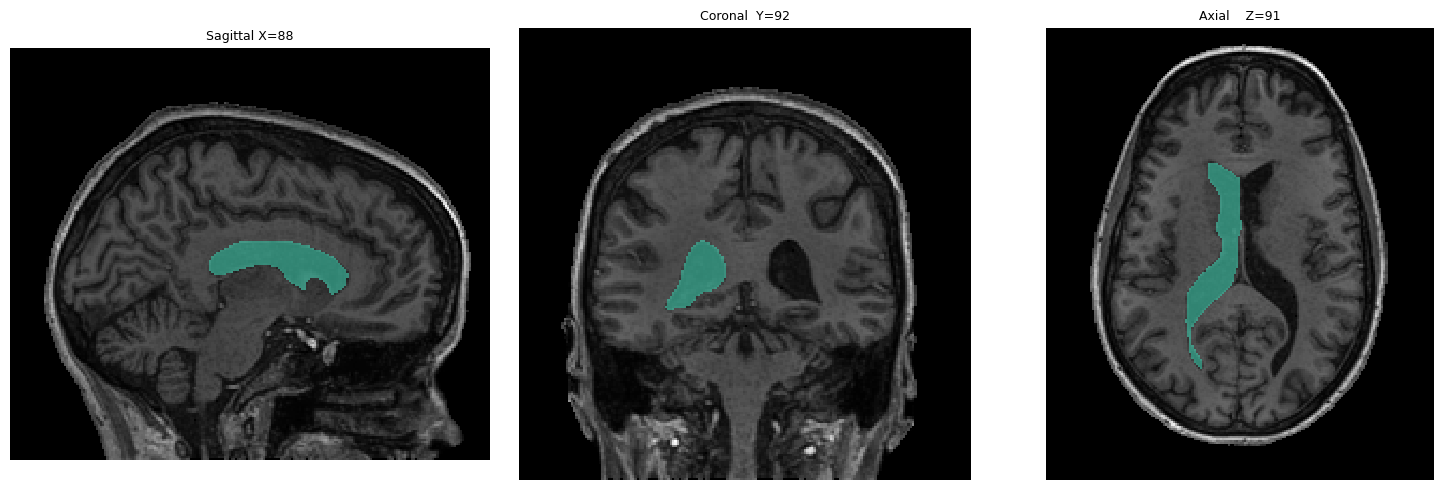

In [ ]:
_ = visualize_slant_subjectid(
    "sub-VUM013_ses-00",
    sagittal_slices=(88),
    coronal_slices=(92),
    axial_slices=(91),
    keep_roi_list=[52],
    bg_t1_file=True,
)
# _ = visualize_t1w_subjectid("sub-013_ses-00", sagittal_slices=(94), coronal_slices=(102) ,axial_slices=(82))

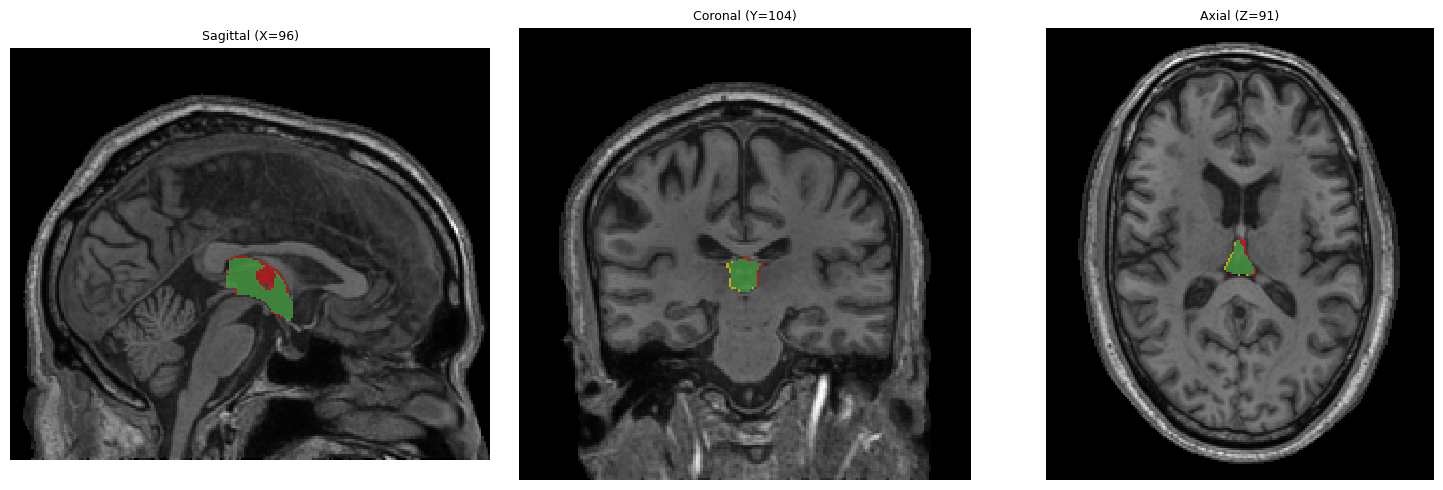

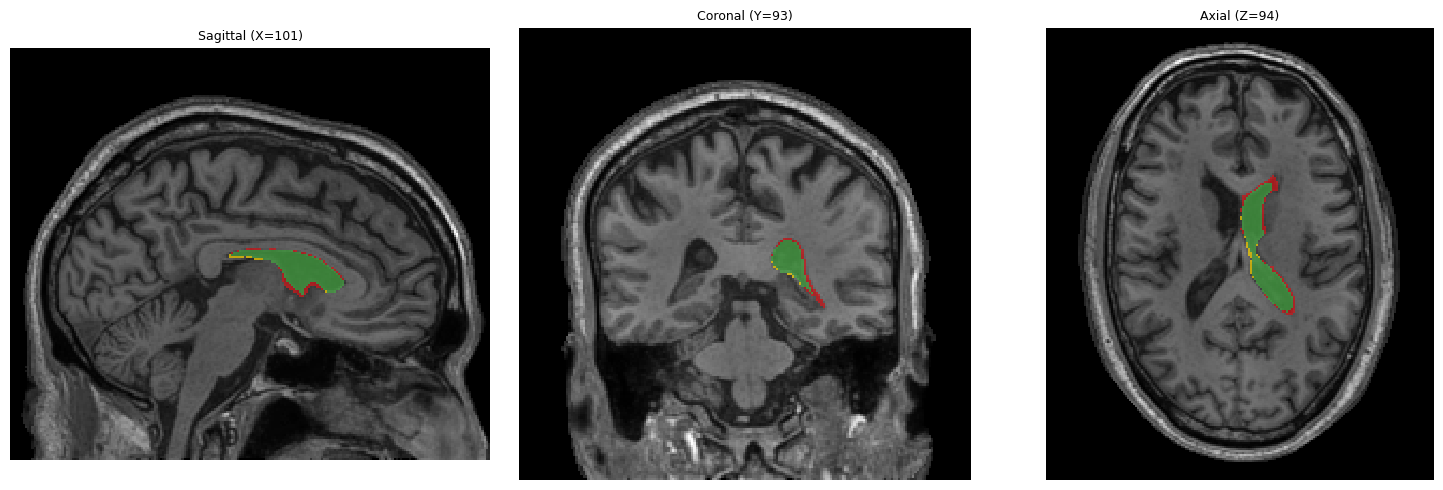

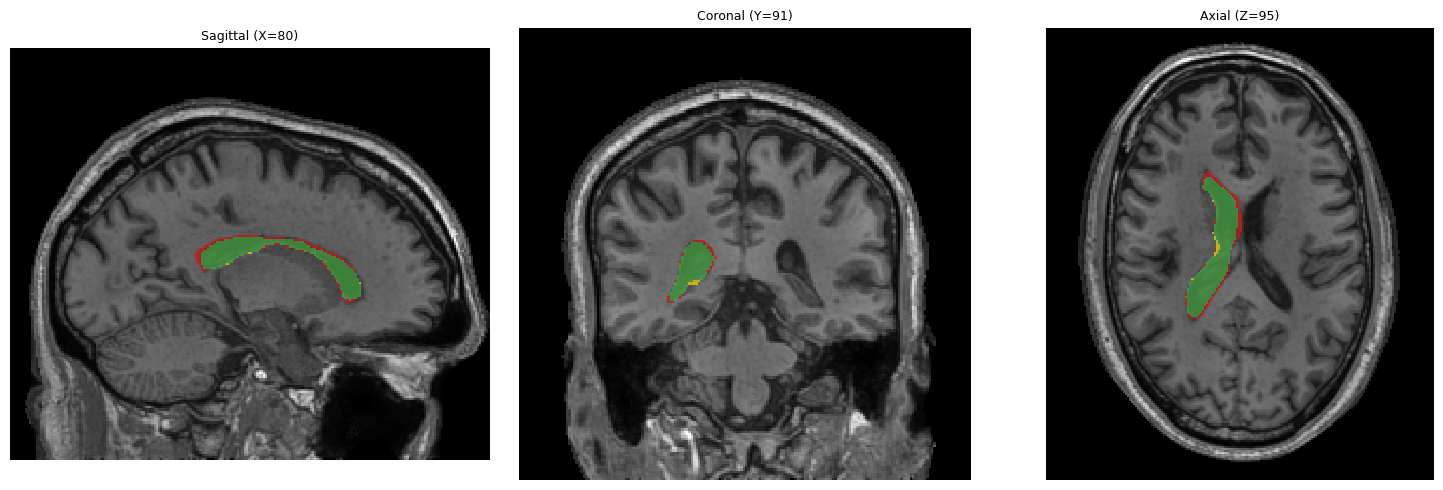

In [ ]:
subjectid = "sub-VUM020"
_ = visualize_slant_subjectid_compare(
    subjectid, keep_roi_list=[4], auto_slice=True, bg_t1_file=True
)
_ = visualize_slant_subjectid_compare(
    subjectid, keep_roi_list=[51], auto_slice=True, bg_t1_file=True
)
_ = visualize_slant_subjectid_compare(
    subjectid, keep_roi_list=[52], auto_slice=True, bg_t1_file=True
)

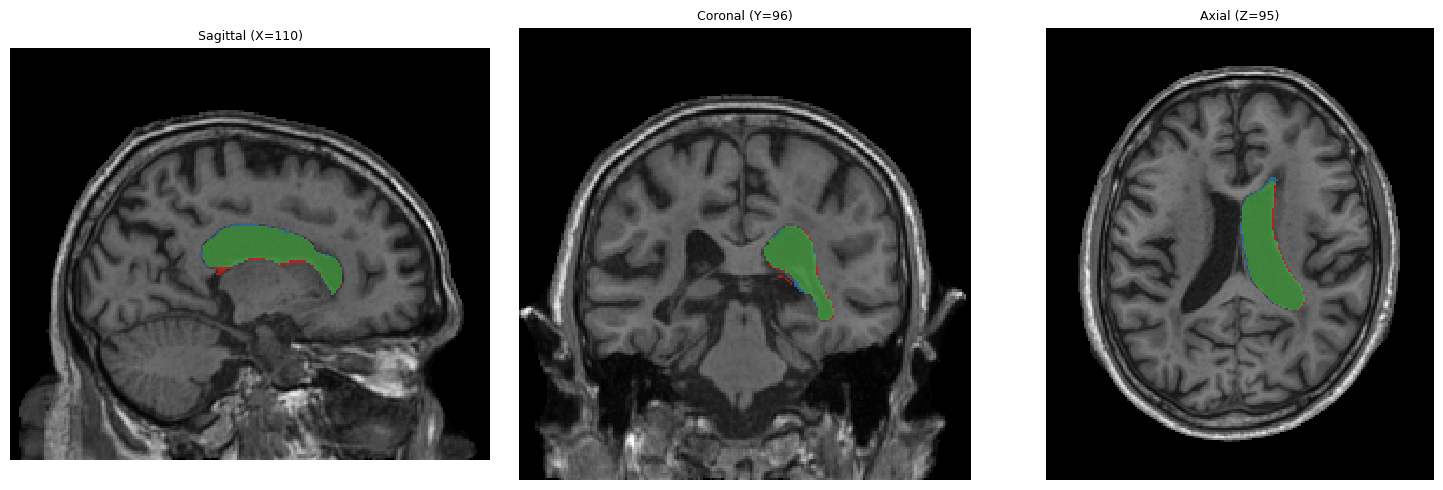

In [ ]:
_ = visualize_slant_subjectid_compare(
    "sub-BRA074", keep_roi_list=[51], auto_slice=True, bg_t1_file=True
)

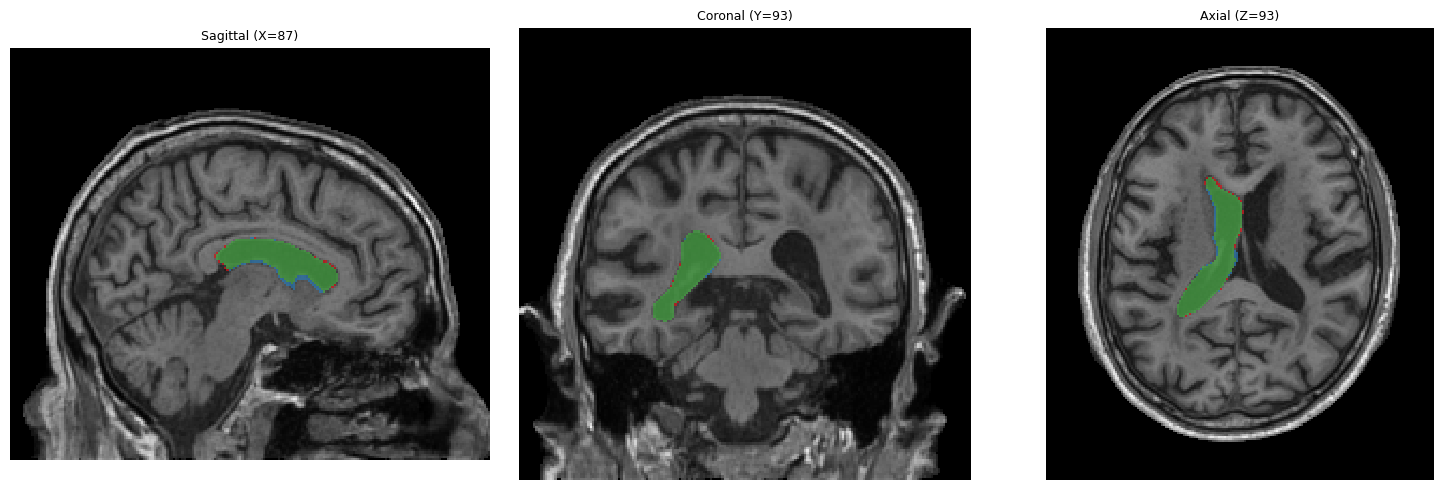

In [ ]:
_ = visualize_slant_subjectid_compare(
    "sub-BRA074", keep_roi_list=[52], auto_slice=True, bg_t1_file=True
)

In [3]:
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

root_dir = cfg["root_dir"]
pattern = cfg["pattern"]
label_index = cfg["label_index"]
roi_volumes_csv = cfg["roi_volumes_csv"]
roi_volumes_csv_z = cfg["roi_volumes_z_csv"]
roi_volumes_csv00 = cfg["roi_volumes_ses00_csv"]
roi_volumes_csv12 = cfg["roi_volumes_ses12_csv"]
roi_volumes_csv00_z = cfg["roi_volumes_ses00_z_csv"]
roi_volumes_csv12_z = cfg["roi_volumes_ses12_z_csv"]
roi_volumes_delta_pct_csv = cfg["roi_volumes_delta_pct_csv"]

In [ ]:
CELL_THR = 3
SUB_THR = 5
ROI_FRAC_THR = 0.05
MAX_ROI_SHOW = 12

zdf = pd.read_csv(roi_volumes_csv_z).set_index("subject").apply(pd.to_numeric)

mask = zdf.abs() >= CELL_THR

print("\n================ Cell-level ==================")
print(
    f"Total cells |z| ≥ {CELL_THR}: {mask.values.sum()} "
    f" / {zdf.size}  ({mask.values.mean():.2%})"
)

print("\n================ Subject-level (≥{SUB_THR} ROI) ================")
sids = []
for sid, cnt in mask.sum(axis=1).sort_values(ascending=False).items():
    if cnt >= SUB_THR:
        rois = zdf.columns[mask.loc[sid]]
        zs = zdf.loc[sid, rois]
        roi_str = ", ".join(f"{r}({zs[r]:+.1f})" for r in rois[:MAX_ROI_SHOW])
        tail = " ..." if len(rois) > MAX_ROI_SHOW else ""
        print(f"{sid:30s}  {cnt:3d} ROI  →  {roi_str}{tail}")
        sids.append(sid)

print(f"\n================ ROI-level (≥{ROI_FRAC_THR:.0%} subjects) ================")
for roi, frac in mask.mean().sort_values(ascending=False).items():
    if frac >= ROI_FRAC_THR:
        n = int(frac * len(zdf))
        print(f"{roi:25s}  {n:3d}/{len(zdf):3d} subjects  ({frac:.1%})")

for subjectid in sids:
    print(f"subject = {subjectid}")
    visualize_slant_subjectid(subjectid, run_number=1, bg_t1_file=True)
    visualize_t1w_subjectid(subjectid, run_number=1)
    # visualize_t1w_subjectid(subjectid, run_number=2)

In [ ]:
vdf_00 = pd.read_csv(roi_volumes_csv00)
vdf_12 = pd.read_csv(roi_volumes_csv12)
plot_roi_compare(vdf_00, vdf_12, 4)
plot_roi_compare(vdf_00, vdf_12, 51)
plot_roi_compare(vdf_00, vdf_12, 52)
delta_pct = pd.read_csv(roi_volumes_delta_pct_csv)
plot_delta_bar(delta_pct, 4, cmap_name="RdBu_r")
plot_delta_bar(delta_pct, 51, cmap_name="RdBu_r")
plot_delta_bar(delta_pct, 52, cmap_name="RdBu_r")
plot_delta_hist_kde(delta_pct, 4, bins=10)
plot_delta_hist_kde(delta_pct, 51, bins=10)
plot_delta_hist_kde(delta_pct, 52, bins=10)
plot_delta_pct_multi_roi(delta_pct, roi_ids=[4, 51, 52])

Saved stats_png/3rd-Ventricle_vol_distribution.png
Saved stats_png/Right-Lateral-Ventricle_vol_distribution.png
Saved stats_png/Left-Lateral-Ventricle_vol_distribution.png


In [33]:
roi_id = 52
col = f"L{roi_id}" if isinstance(roi_id, int) else str(roi_id)

if col not in delta.columns:
    raise KeyError(f"{col=} not found in delta DataFrame")

roi_delta = delta[col].dropna()

sub_max = roi_delta.idxmax()
sub_min = roi_delta.idxmin()
val_max = roi_delta.max()
val_min = roi_delta.min()

print(f"\nROI {col}:")
print(f"  Max Δ% = {val_max:+.2f}  (subject: {sub_max})")
print(f"  Min Δ% = {val_min:+.2f}  (subject: {sub_min})")

mean, sd = roi_delta.mean(), roi_delta.std(ddof=1)
upper_th = mean + 3 * sd
lower_th = mean - 3 * sd


def flag_outlier(value):
    return "  <== OUTLIER" if (value > upper_th or value < lower_th) else ""


print(f"  Mean ±3SD range: [{lower_th:+.2f}, {upper_th:+.2f}]")
print(f"  Max point: {flag_outlier(val_max)}")
print(f"  Min point: {flag_outlier(val_min)}")


ROI L52:
  Max Δ% = +25.19  (subject: sub-BRA033)
  Min Δ% = -19.65  (subject: sub-VUM013)
  Mean ±3SD range: [-29.63, +23.96]
  Max point:   <== OUTLIER
  Min point: 


In [ ]:
df_vol = pd.read_csv("stats_csv/roi_volumes_vum.csv")
df_vol["VUM_ID"] = df_vol["subject"].str.extract(r"sub-(.*?)_ses")
df_vol["SessionID"] = df_vol["subject"].str.extract(r"ses-(.*)")
df_long = df_vol.melt(
    id_vars=["subject", "VUM_ID", "SessionID"], var_name="ROI", value_name="Volume"
)
df_long["interval"] = (df_long["SessionID"].astype(int) == 12).astype(int)

df_meta = pd.read_csv("labels/vum_metadata.csv", dtype={"SessionID": str})
df = df_long.merge(df_meta, on=["VUM_ID", "SessionID"], how="left").rename(
    columns={"PatientAge": "age", "PatientSex": "sex", "PatientWeight": "weight"}
)
df["age_z"] = (df["age"] - df["age"].mean()) / df["age"].std(ddof=0)
df["weight_z"] = (df["weight"] - df["weight"].mean()) / df["weight"].std(ddof=0)
df["sex"] = df["sex"].astype("category")

rows = []
for roi, df_roi in df.groupby("ROI"):
    md = smf.mixedlm(
        "Volume ~ age_z + C(sex) + weight_z + interval",
        df_roi,
        groups=df_roi["subject"],
    )
    mdf = md.fit(reml=False)
    beta = mdf.params["interval"]
    pval = mdf.pvalues["interval"]
    ci_low, ci_high = mdf.conf_int().loc["interval"]
    resid_sd = np.sqrt(mdf.scale)
    cohend = beta / resid_sd
    rows.append(
        {
            "ROI": roi,
            "beta": beta,
            "pval": pval,
            "ci_lower": ci_low,
            "ci_upper": ci_high,
            "cohen_d": cohend,
        }
    )
    print(
        f"ROI={roi:>6}  β={beta:+.3f} 95%CI=[{ci_low:+.3f},{ci_high:+.3f}]  "
        f"p={pval:.3f}  d={cohend:.3f}"
    )
out_df = pd.DataFrame(rows)
out_df.to_csv("roi_interval_lmm.csv", index=False)
print("Saved interval-effect summary to roi_interval_effects.csv")

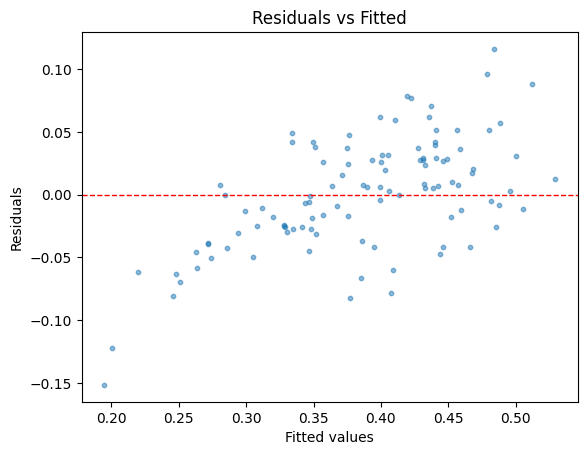

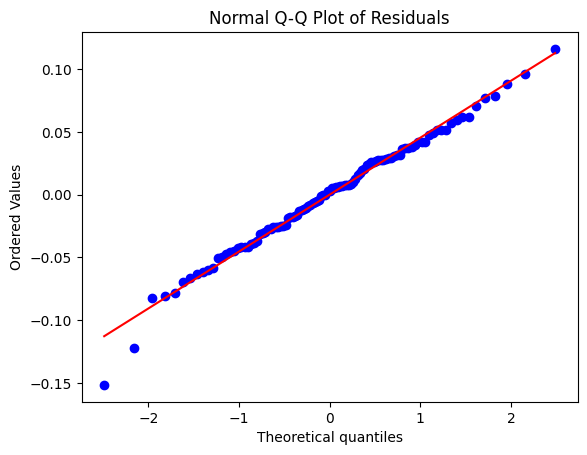

In [37]:
fitted = mdf.fittedvalues
resid = mdf.resid

plt.scatter(fitted, resid, alpha=0.5, s=10)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

import scipy.stats as stats

stats.probplot(resid, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot of Residuals")
plt.show()

In [35]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

df_vol = pd.read_csv("stats_csv/roi_volumes_vum_00and12.csv")

df_vol["VUM_ID"] = df_vol["subject"].str.extract(r"sub-(.*?)_ses")
df_vol["SessionID"] = df_vol["subject"].str.extract(r"ses-(.*)")

df_long = df_vol.melt(
    id_vars=["subject", "VUM_ID", "SessionID"],
    var_name="ROI",
    value_name="Volume",
)

df_long["interval"] = (df_long["SessionID"].astype(int) == 12).astype(int)

df_meta = pd.read_csv("labels/vum_metadata.csv", dtype={"SessionID": str})
df = df_long.merge(df_meta, on=["VUM_ID", "SessionID"], how="left").rename(
    columns={"PatientAge": "age", "PatientSex": "sex", "PatientWeight": "weight"}
)

df["age_z"] = (df["age"] - df["age"].mean()) / df["age"].std(ddof=0)
df["weight_z"] = (df["weight"] - df["weight"].mean()) / df["weight"].std(ddof=0)

df["sex"] = df["sex"].astype("category")

rows = []
for roi, df_roi in df.groupby("ROI"):
    lm = smf.ols("Volume ~ age_z + C(sex) + weight_z + interval", data=df_roi)
    res = lm.fit()

    beta = res.params["interval"]
    pval = res.pvalues["interval"]
    ci_low, ci_high = res.conf_int().loc["interval"]

    resid_sd = res.resid.std(ddof=0)
    cohend = beta / resid_sd

    rows.append(
        {
            "ROI": roi,
            "beta_int": beta,
            "pval_int": pval,
            "ci_lower": ci_low,
            "ci_upper": ci_high,
            "cohen_d": cohend,
        }
    )

    print(
        f"ROI={roi:>6}  β_interval={beta:+.3f}  "
        f"95% CI=[{ci_low:+.3f}, {ci_high:+.3f}]  "
        f"p={pval:.3f}  d={cohend:.3f}"
    )

out_df = pd.DataFrame(rows)
out_df.to_csv("roi_interval_ols.csv", index=False)
print("Saved summary to roi_interval_ols.csv")

ROI=    L0  β_interval=-0.621  95% CI=[-61.090, +59.848]  p=0.984  d=-0.007
ROI=  L100  β_interval=-0.021  95% CI=[-0.519, +0.478]  p=0.934  d=-0.027
ROI=  L101  β_interval=+0.096  95% CI=[-0.469, +0.661]  p=0.733  d=0.110
ROI=  L102  β_interval=+0.059  95% CI=[-0.218, +0.337]  p=0.667  d=0.139
ROI=  L103  β_interval=+0.006  95% CI=[-0.280, +0.291]  p=0.967  d=0.013
ROI=  L104  β_interval=+0.087  95% CI=[-0.131, +0.305]  p=0.423  d=0.260
ROI=  L105  β_interval=+0.045  95% CI=[-0.202, +0.292]  p=0.715  d=0.118
ROI=  L106  β_interval=+0.441  95% CI=[-0.475, +1.357]  p=0.336  d=0.312
ROI=  L107  β_interval=+0.072  95% CI=[-0.859, +1.003]  p=0.877  d=0.050
ROI=  L108  β_interval=+0.028  95% CI=[-0.371, +0.428]  p=0.886  d=0.046
ROI=  L109  β_interval=+0.052  95% CI=[-0.297, +0.400]  p=0.766  d=0.096
ROI=   L11  β_interval=-0.026  95% CI=[-0.332, +0.279]  p=0.861  d=-0.056
ROI=  L112  β_interval=+0.042  95% CI=[-0.357, +0.440]  p=0.834  d=0.068
ROI=  L113  β_interval=+0.049  95% CI=[-0.308,

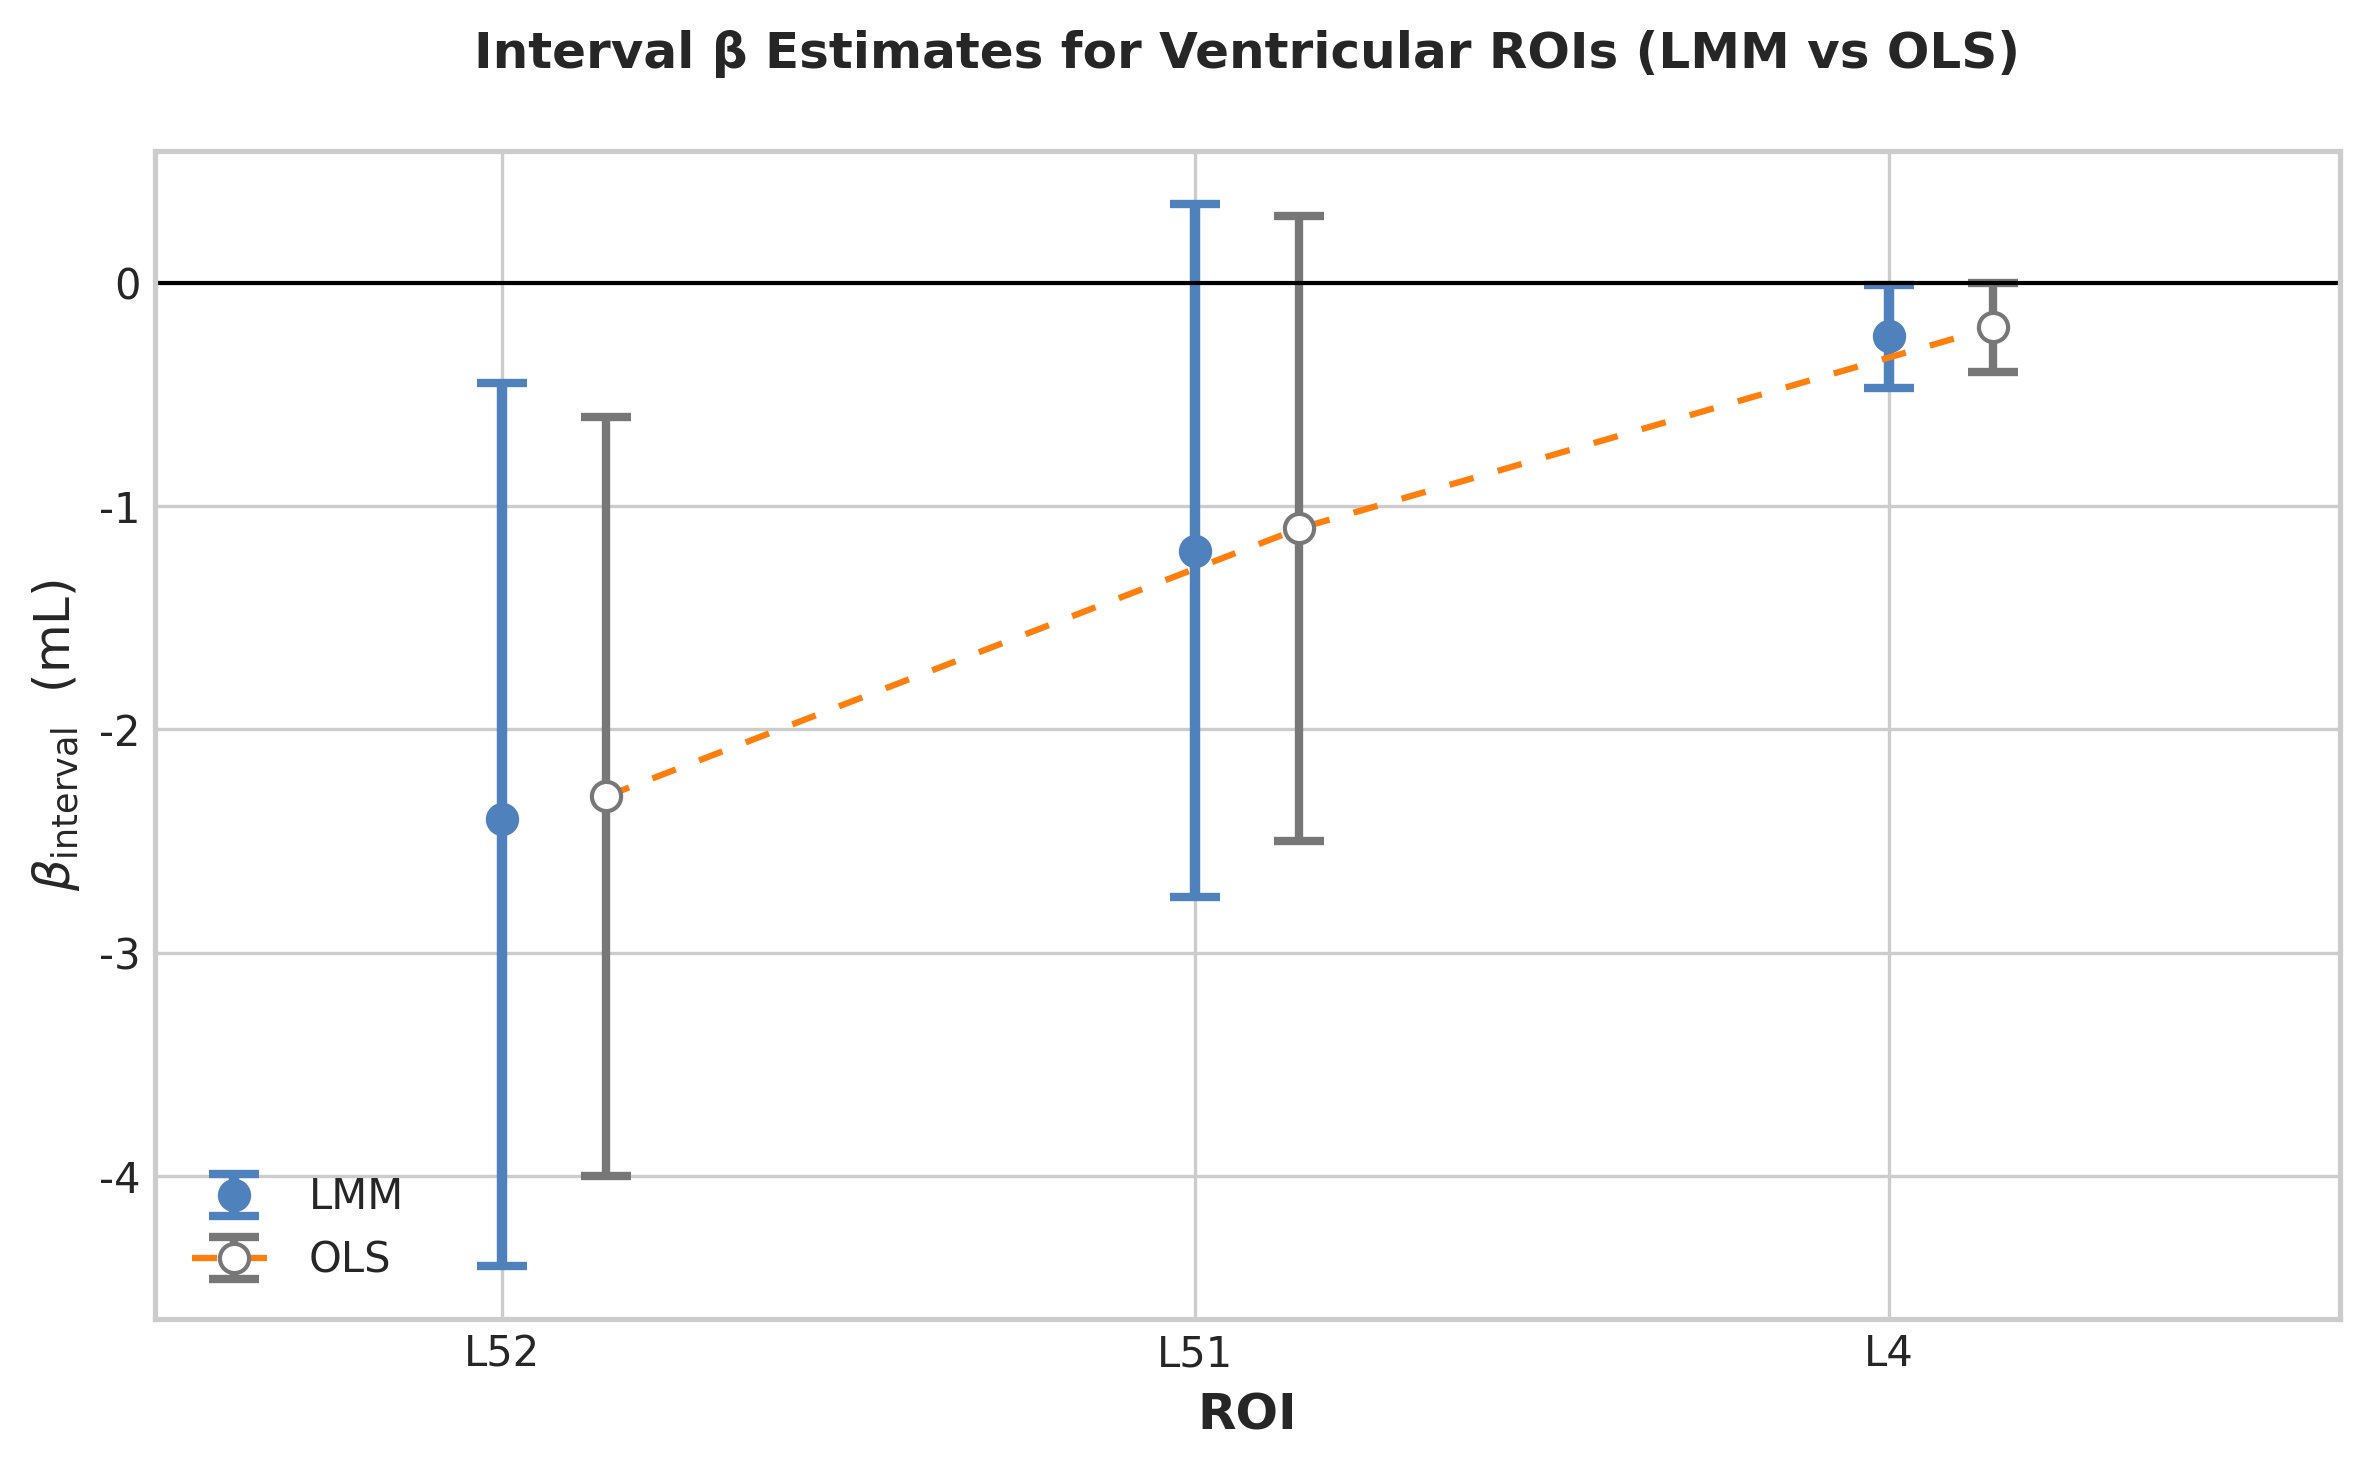

In [124]:
import matplotlib.pyplot as plt

rois      = ["L52", "L51", "L4"]
beta_lmm  = [-2.4, -1.2, -0.24]
ci_lmm    = [(-4.4, -0.45), (-2.75, 0.35), (-0.47, -0.01)]
beta_ols  = [-2.3, -1.1, -0.20]
ci_ols    = [(-4.0, -0.6), (-2.5,  0.3),   (-0.4,  0.0)]

x = range(len(rois))
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

# ---------- LMM ----------
ax.errorbar(
    x,
    beta_lmm,
    yerr=[
        [b - lo for b, (lo, _) in zip(beta_lmm, ci_lmm)],   # 下误差
        [hi - b for b, (_, hi) in zip(beta_lmm, ci_lmm)],   # 上误差
    ],
    fmt="o",
    markersize=7,
    markerfacecolor="#4F81BD",
    markeredgecolor="#4F81BD",
    ecolor="#4F81BD",
    elinewidth=2.5,      # 误差线粗
    capsize=6,           # 横帽长度
    capthick=2,          # 横帽粗细
    label="LMM",
)

# ---------- OLS ----------
ax.errorbar(
    [v + 0.15 for v in x],
    beta_ols,
    yerr=[
        [b - lo for b, (lo, _) in zip(beta_ols, ci_ols)],
        [hi - b for b, (_, hi) in zip(beta_ols, ci_ols)],
    ],
    fmt="o",
    markersize=7,
    markerfacecolor="white",
    markeredgecolor="#777777",
    ecolor="#777777",
    elinewidth=2.0,
    capsize=6,
    capthick=2,
    linestyle="--",
    dashes=(4, 4),
    label="OLS",
)

# 参考线
ax.axhline(0, color="k", lw=1)

# 坐标轴 & 标签
ax.set_xticks(x)
ax.set_xticklabels(rois)
ax.set_xlabel("ROI", fontsize=12, fontweight="bold")
ax.set_ylabel(r"$\beta_{\mathrm{interval}}$  (mL)",fontsize=12)
ax.set_xlim(-0.5, len(rois)-0.35) 
ax.legend(frameon=False)


plt.title(
        "Interval β Estimates for Ventricular ROIs (LMM vs OLS)", fontsize=12, fontweight="bold", pad=20
    )
plt.tight_layout()
plt.show()

Figure saved to: bh_fdr_correction.png

BH FDR Correction Results:
ROI     p  bh_threshold  significant
L52 0.010        0.0167         True
 L4 0.027        0.0333         True
L51 0.129        0.0500        False


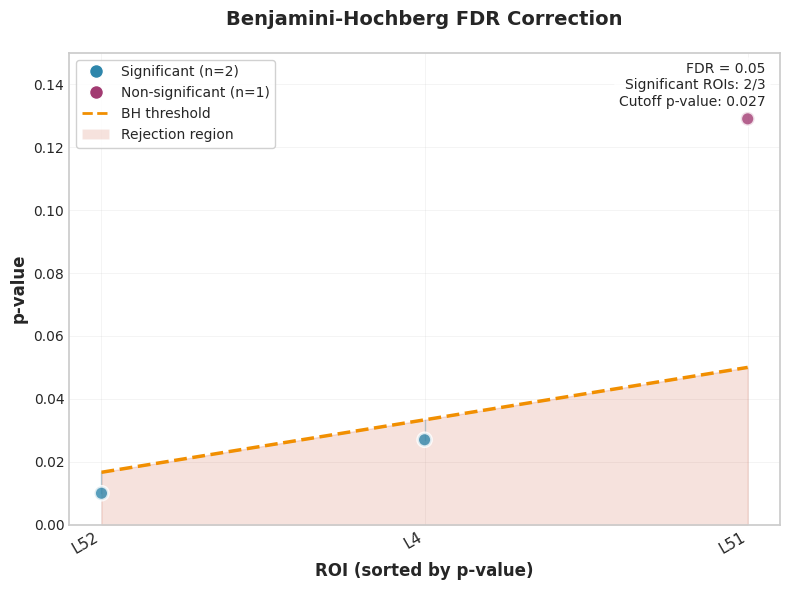

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle


def plot_bh_fdr_correction(
    roi_data, q_value=0.05, figsize=(8, 6), save_path=None, dpi=300
):
    # Data preparation and BH correction calculation
    df = pd.DataFrame(roi_data).sort_values("p").reset_index(drop=True)
    m = len(df)

    df["rank"] = df.index + 1
    df["bh_threshold"] = df["rank"] / m * q_value

    # Find the largest p-value satisfying p(i) ≤ (i/m)·Q
    significant_mask = df["p"] <= df["bh_threshold"]
    if significant_mask.any():
        bh_cutoff = df.loc[significant_mask, "p"].max()
    else:
        bh_cutoff = 0

    df["significant"] = df["p"] <= bh_cutoff

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize, facecolor="white")

    x = np.arange(m)

    # Color scheme
    colors = {
        "significant": "#2E86AB",
        "non_significant": "#A23B72",
        "threshold_line": "#F18F01",
        "fill_area": "#C73E1D",
    }

    # Fill area below BH threshold
    ax.fill_between(
        x,
        0,
        df["bh_threshold"],
        color=colors["fill_area"],
        alpha=0.15,
        label=f"Rejection region (Q = {q_value})",
    )

    # BH threshold line
    ax.plot(
        x,
        df["bh_threshold"],
        linestyle="--",
        linewidth=2.5,
        color=colors["threshold_line"],
        label="BH threshold line",
        zorder=3,
    )

    # Scatter plot of p-values
    scatter = ax.scatter(
        x,
        df["p"],
        s=100,
        c=df["significant"].map(
            {True: colors["significant"], False: colors["non_significant"]}
        ),
        edgecolor="white",
        linewidth=2,
        alpha=0.8,
        zorder=4,
    )

    # Add connection lines for significant points
    for i in range(m):
        if df.iloc[i]["significant"]:
            ax.plot(
                [x[i], x[i]],
                [df.iloc[i]["p"], df.iloc[i]["bh_threshold"]],
                color=colors["significant"],
                alpha=0.3,
                linewidth=1,
            )

    # Axis settings
    ax.set_xticks(x)
    ax.set_xticklabels(df["ROI"], rotation=30, ha="right", fontsize=11)
    ax.set_xlabel("ROI (sorted by p-value)", fontsize=12, fontweight="bold")
    ax.set_ylabel("p-value", fontsize=12, fontweight="bold")

    # Y-axis range
    y_max = max(df[["p", "bh_threshold"]].values.max() * 1.15, 0.15)
    ax.set_ylim(0, y_max)

    # Grid
    ax.grid(True, alpha=0.3, linestyle="-", linewidth=0.5)

    # Custom legend
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=colors["significant"],
            markersize=10,
            label=f'Significant (n={df["significant"].sum()})',
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=colors["non_significant"],
            markersize=10,
            label=f'Non-significant (n={(~df["significant"]).sum()})',
        ),
        plt.Line2D(
            [0],
            [0],
            color=colors["threshold_line"],
            linestyle="--",
            linewidth=2,
            label="BH threshold",
        ),
        Rectangle(
            (0, 0),
            1,
            1,
            facecolor=colors["fill_area"],
            alpha=0.15,
            label="Rejection region",
        ),
    ]

    ax.legend(
        handles=legend_elements,
        loc="upper left",
        frameon=True,
        framealpha=0.9,
        fontsize=10,
    )

    # Statistics text box
    stats_text = f"FDR = {q_value}\nSignificant ROIs: {df['significant'].sum()}/{m}"
    if bh_cutoff > 0:
        stats_text += f"\nCutoff p-value: {bh_cutoff:.3f}"

    ax.text(
        0.98,
        0.98,
        stats_text,
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        fontsize=10,
    )

    plt.title(
        "Benjamini-Hochberg FDR Correction", fontsize=14, fontweight="bold", pad=20
    )
    plt.tight_layout()

    # Save or show
    if save_path:
        plt.savefig(
            save_path, dpi=dpi, bbox_inches="tight", facecolor="white", edgecolor="none"
        )
        print(f"Figure saved to: {save_path}")
    else:
        plt.show()

    return fig, ax, df


# Usage example
if __name__ == "__main__":
    # Original data
    data = {
        "ROI": ["L52", "L4", "L51"],
        "p": [0.01, 0.027, 0.129],
    }

    # Create the plot
    fig, ax, results = plot_bh_fdr_correction(
        data, q_value=0.05, save_path="bh_fdr_correction.png"
    )

    # Print results summary
    print("\nBH FDR Correction Results:")
    summary = results[["ROI", "p", "bh_threshold", "significant"]].copy()
    summary["bh_threshold"] = summary["bh_threshold"].round(4)
    summary["p"] = summary["p"].round(4)
    print(summary.to_string(index=False))